In [1]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')  # ignore warnings, like ZeroDivision

project_root = os.path.abspath('..')
sys.path.append(project_root)

In [2]:
from src.utils_data import *
from src.transformation_utils import *
from src.utils_all import *
from src.GAN.SrGAN_RTM_trainer import *

In [3]:
import pickle

import torch
from torch.utils.data import DataLoader, TensorDataset
from huggingface_hub import hf_hub_download

In [4]:
print(torch.__version__)
print(torch.cuda.is_available())

# Check if GPU is available
if torch.cuda.is_available():
    # Set the device to GPU
    device = torch.device("cuda")
    print("GPU is available. Using GPU for computation.")
else:
    # If GPU is not available, fall back to CPU
    device = torch.device("cpu")
    print("GPU is not available. Using CPU for computation.")

1.8.1+cu111
True
GPU is available. Using GPU for computation.


In [6]:
def load_model(main_path, input_shape, type_s, perc=100):
    
    # open a file, where you stored the pickled data
    file = open(os.path.join(main_path, 'scaler_all_{}.pkl'.format(perc)), 'rb') 
    path_model = os.path.join(main_path, 'best_model.h5')

    # dump information to that file
    scaler_list = pickle.load(file)

    settings_dict = {
        'checkpoint_dir': None,
        'train_loader': None,
        'valid_loader': None,
        'unlabeled_loader': None, 
        
        'scaler_model': scaler_list,
        'n_lb': 8, #y_train.shape[1],
        'input_shape': input_shape,
        'type':type_s,
        'latent_dim': 100,
        'learning_rate': None,
        'weight_decay': None,
        
        'n_epochs': None,
        'batch_size': None,
        
        'rtm_D': True,
        'rtm_G': True,
        
        'lambda_fk': 1.0,
        'lambda_un': 10.0,
        
        'labeled_loss_multiplier': 1.0,
        'matching_loss_multiplier': 1.0,
        'contrasting_loss_multiplier': 1.0,
        
        'gradient_penalty_on': True,
        'gradient_penalty_multiplier': 10.0,
        'srgan_loss_multiplier': 1.0,
        
        'early_stop': True,
        'early_stopping': None,
        'patience': None,
        'logger': None,
        'log_epoch': None,
        
        'mean_offset': None,
        'normalize_fake_loss': False,
        'normalize_feature_norm': False,
        
        'contrasting_distance_function': nn.CosineEmbeddingLoss(),
        'matching_distance_function': nn.CosineEmbeddingLoss(),
        'labeled_loss_function': HuberCustomLoss(threshold=1.0),

        'device': torch.device("cuda" if torch.cuda.is_available() else "cpu")
    }
    sets = Settings()
    sets.update_from_dict(settings_dict)

    test_reg = SrGAN_RTM(sets)
    test_reg.dataset_setup()
    test_reg.model_setup()
    test_reg.transformation_setup()
    
    test_reg.model = torch.load(path_model) #, map_location=torch.device('cpu')
    return test_reg

def load_model_HF(repo_id, model_id, input_shape, type_s, perc=100):
    # Download files from Hugging Face Hub
    config_file = hf_hub_download(
        repo_id=repo_id,
        filename= os.path.join(model_id, 'scaler_all_{}.pkl'.format(perc))
    )

    path_model = hf_hub_download(
        repo_id=repo_id,
        filename=os.path.join(model_id, 'best_model.h5')
    )

    # Load pickled scaler
    with open(config_file, 'rb') as f:
        scaler_list = pickle.load(f)

    settings_dict = {
        'checkpoint_dir': None,
        'train_loader': None,
        'valid_loader': None,
        'unlabeled_loader': None, 
        
        'scaler_model': scaler_list,
        'n_lb': 8, #y_train.shape[1],
        'input_shape': input_shape,
        'type':type_s,
        'latent_dim': 100,
        'learning_rate': None,
        'weight_decay': None,
        
        'n_epochs': None,
        'batch_size': None,
        
        'rtm_D': True,
        'rtm_G': True,
        
        'lambda_fk': 1.0,
        'lambda_un': 10.0,
        
        'labeled_loss_multiplier': 1.0,
        'matching_loss_multiplier': 1.0,
        'contrasting_loss_multiplier': 1.0,
        
        'gradient_penalty_on': True,
        'gradient_penalty_multiplier': 10.0,
        'srgan_loss_multiplier': 1.0,
        
        'early_stop': True,
        'early_stopping': None,
        'patience': None,
        'logger': None,
        'log_epoch': None,
        
        'mean_offset': None,
        'normalize_fake_loss': False,
        'normalize_feature_norm': False,
        
        'contrasting_distance_function': nn.CosineEmbeddingLoss(),
        'matching_distance_function': nn.CosineEmbeddingLoss(),
        'labeled_loss_function': HuberCustomLoss(threshold=1.0),

        'device': torch.device("cuda" if torch.cuda.is_available() else "cpu")
    }
    sets = Settings()
    sets.update_from_dict(settings_dict)

    test_reg = SrGAN_RTM(sets)
    test_reg.dataset_setup()
    test_reg.model_setup()
    test_reg.transformation_setup()
    
    test_reg.model = torch.load(path_model) #, map_location=torch.device('cpu')

    return test_reg

def eval(valid_loader, input_shape, type_s, perc=100, HF=False, model_id=None, repo_id=None, main_path=None):
    if(HF):
        test_reg = load_model_HF(repo_id, model_id, input_shape, type_s, perc=100)
    else:
        test_reg = load_model(main_path, input_shape, type_s, perc=perc)

    preds = torch.empty(0,8).to(device)
    ori = torch.empty(0,8).to(device)

    test_reg.eval_mode()

    with torch.no_grad():
        for data_val, lb_bx_val in valid_loader:
            lb_bx_val = lb_bx_val.float().to(device)
            data_val = data_val.unsqueeze(dim=1)[:,:,:-1].float().to(device)

            pred = test_reg.model(data_val)[0]

            if(test_reg.settings.scaler_model is not None):
                preds_D = test_reg.transformation_layer_inv(pred) ### shoud keep the sam eorder of labels !!!
                
            elif(test_reg.settings.scaler_list is not None):
                preds_D = torch.tensor(test_reg.settings.scaler_list.inverse_transform(pred.cpu().detach().numpy()), dtype=torch.float32)#.requires_grad_(True)
            else:
                preds_D = pred.clone

            ori = torch.cat((ori.data, lb_bx_val.data), dim=0)
            preds = torch.cat((preds.data, preds_D.data), dim=0)

    ori_lb = pd.DataFrame(ori.cpu(), columns=ls_tr[:])
    df_tr_val = pd.DataFrame(preds.cpu(), columns=ls_tr[:])

    return ori_lb, df_tr_val


In [ ]:
ls_tr = ["cab", "cw", "cm", "LAI", "cp", "cbc", "car", "anth"]

perc = 100
seed_all(seed=4)

# ### if locally
# checkpoints_path = 'gan_model/checkpoints_Gan_NoRTM_250507_1536_gp0UNlabels_155/'
# main_path = os.path.join(project_root, checkpoints_path) 

##### Or on HF ##
repo_id = "Avatarr05/Multi-trait_SSL"
model_id = 'Gans_models/checkpoints_GanFR_seed140'

In [7]:
from datasets import load_dataset

### labeled_splits: train ###
test_dataset = load_dataset("Avatarr05/GreenHyperSpectra", 'labeled_splits', split="test")
test_dataset = test_dataset.to_pandas().drop(['Unnamed: 0', ], axis=1)

X_val = test_dataset.loc[:, '400':'2450']
y_val = test_dataset[ls_tr]

meta_val = test_dataset.iloc[:, :1]

# Validation dataset
x_p_val = torch.tensor(X_val.values, dtype=torch.float)
lb_p_val = torch.tensor(y_val.values,dtype=torch.float)

test_dataset = TensorDataset(x_p_val, lb_p_val)
valid_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [8]:
### On HF ##
ori_lb, df_tr_val = eval(valid_loader, 1720, 'full', perc=100, HF=True, model_id=model_id, repo_id=repo_id)
# ## Locally 
# ori_lb, df_tr_val = eval(valid_loader, 1720, 'full', perc=100, main_path=main_path)

eval_metrics(ori_lb, df_tr_val)

,r2_score,RMSE,nRMSE (%),MAE,Bias,RPD,spearmanr_squared
cab,0.619587,8.362829,15.386735,5.959668,3.903758e-01,1.623385,0.659491
cw,0.668746,0.005173,12.243581,0.003236,-6.108243e-05,1.739532,0.630488
cm,0.727288,0.003309,9.674292,0.002045,-9.152978e-07,1.916211,0.666624
LAI,0.633324,1.069601,15.889516,0.764302,9.812017e-02,1.654340,0.639624
cp,0.606649,0.000276,10.920597,0.000173,1.086583e-05,1.595884,0.653220
cbc,0.769374,0.003068,9.048053,0.001896,-7.828267e-05,2.084191,0.674193
car,0.662326,1.663964,11.742896,1.165419,1.147429e-01,1.723536,0.675340
anth,0.598995,0.273858,14.114419,0.198897,2.819937e-02,1.590086,0.519883


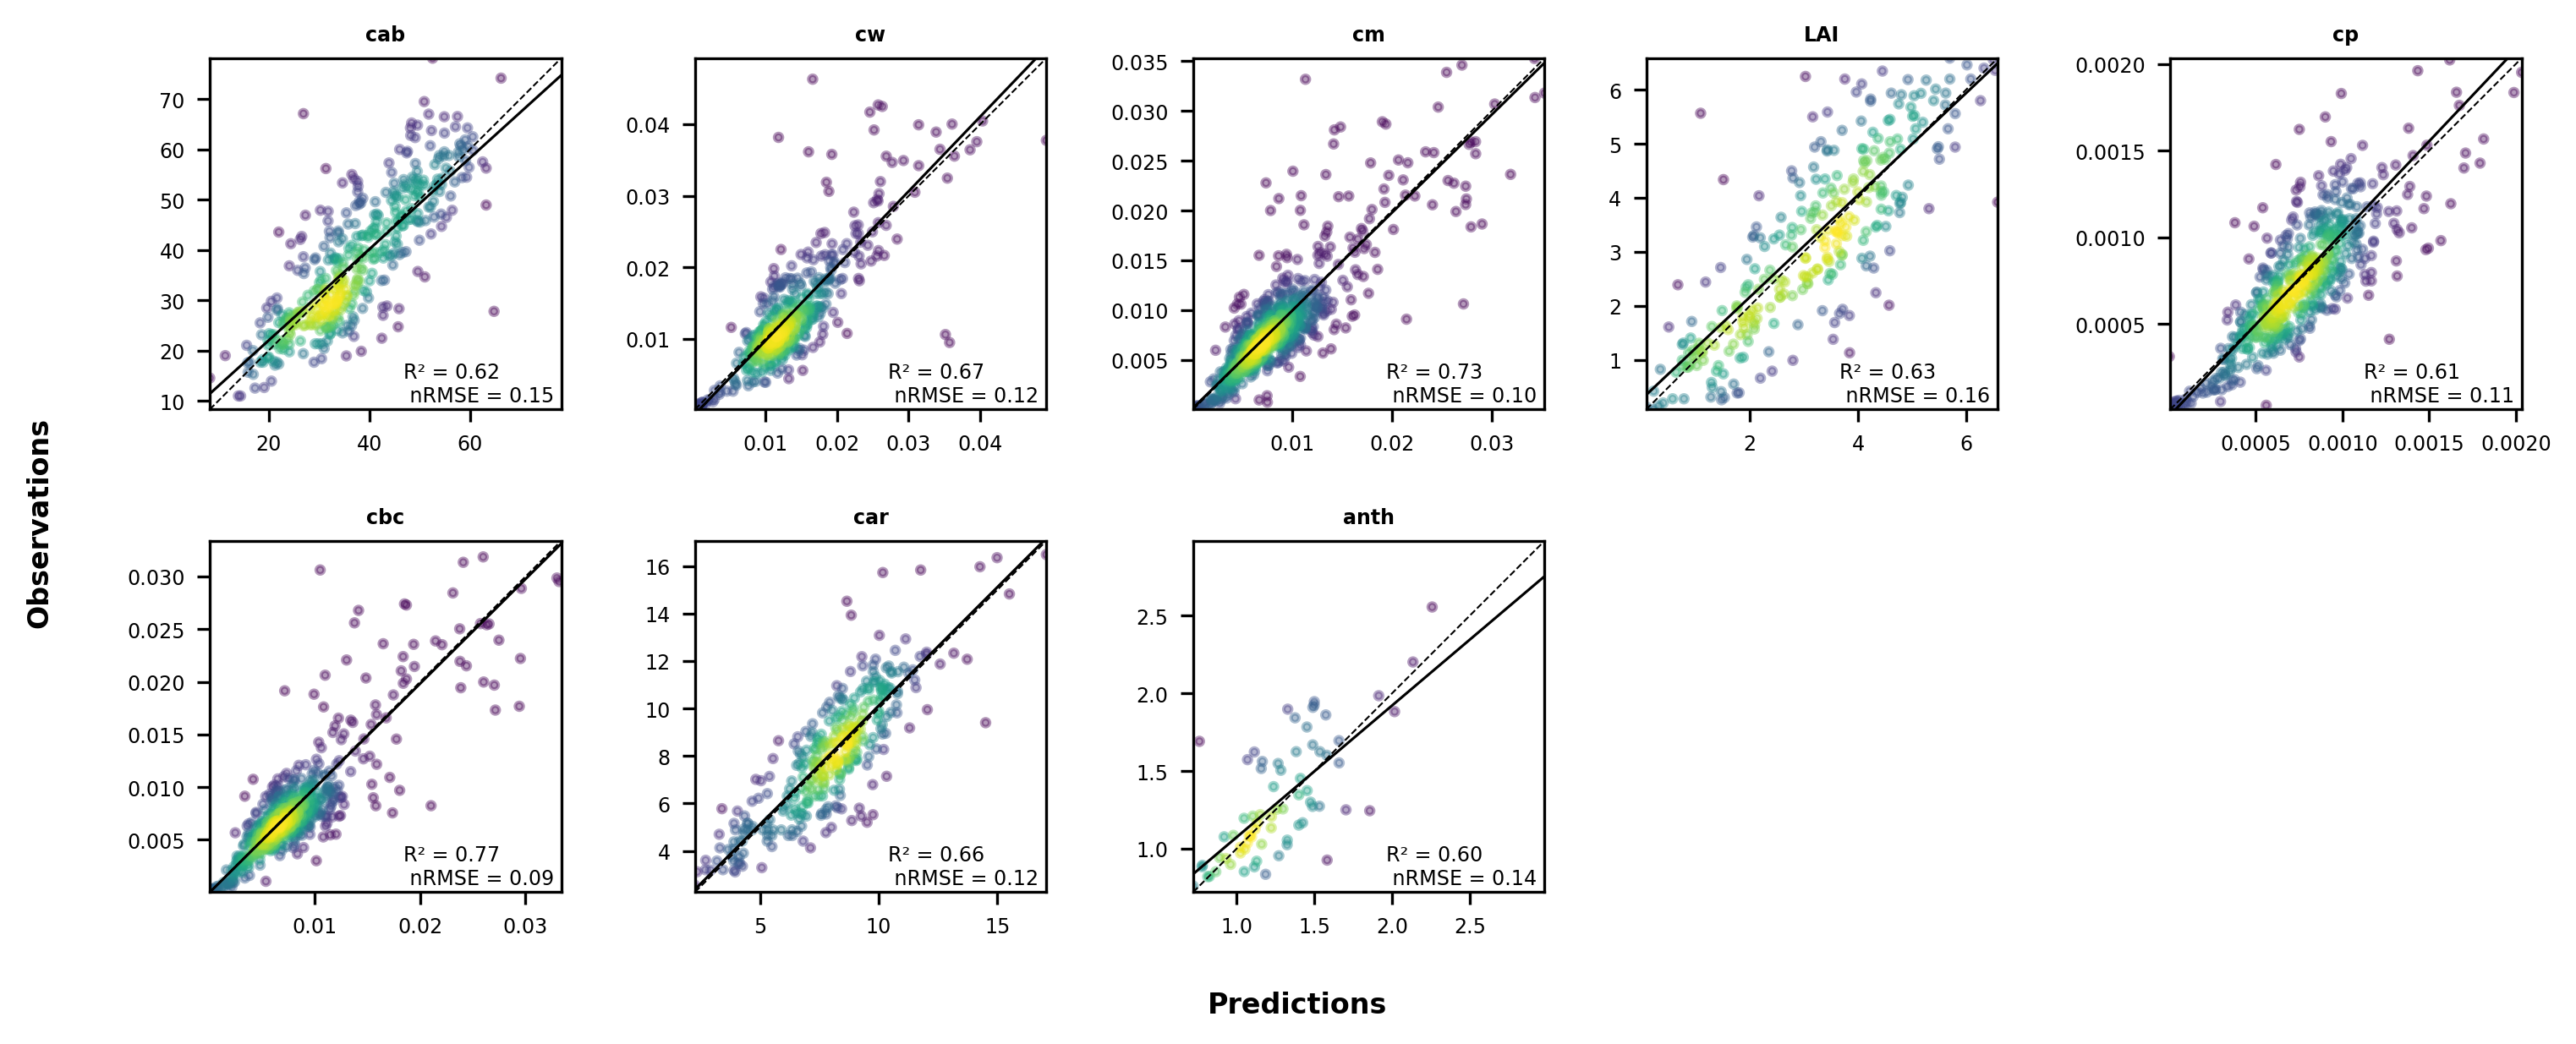

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from scipy.stats import gaussian_kde

import seaborn as sns

# --- Settings ---
size = 5.7
quantile_vis = 1
figsize = (10, 4)

plt.rc('font', size=size)
plt.rcParams['lines.markersize'] = 3
plt.rcParams['lines.linewidth'] = 0.5

a = 2  # rows
b = 5  # columns
c = 1  # subplot counter

# --- Prepare data --- 
Traits = test_tr = list(ori_lb.columns)

fig = plt.figure(figsize=figsize, dpi=300, constrained_layout=True)

for tr in range(len(test_tr)):
    pred = df_tr_val.iloc[:, tr]
    true = ori_lb.iloc[:, tr]

    norm = (np.nanquantile(true, 0.99) - np.nanquantile(true, 0.01))

    # Reset indices and align data
    f = pred.copy().reset_index(drop=True)
    y = true.copy().reset_index(drop=True)

    # Drop NaNs
    idx = np.union1d(f[f.isna()].index, y[y.isna()].index)
    f.drop(idx, inplace=True)
    y.drop(idx, inplace=True)

    # Metrics
    r2 = r2_score(y, f)
    nrmse = math.sqrt(mean_squared_error(y, f)) / norm
    nmae = mean_absolute_error(y, f) / norm

    # Plotting
    ax1 = plt.subplot(a, b, c)
    plt.axis('square')

    lim_max = min(f.quantile(quantile_vis), y.quantile(quantile_vis))
    lim_min = max(f.quantile(1 - quantile_vis), y.quantile(1 - quantile_vis))

    ax1.set_xlim(lim_min, lim_max)
    ax1.set_ylim(ax1.get_xlim())
    ax1.set_aspect('equal', adjustable='box')

    # Diagonal reference line
    sns.lineplot(x=(lim_min, lim_max), y=(lim_min, lim_max),
                 ax=ax1, color='black', linestyle='dashed', legend=False)

    # --- Density coloring ---
    xy = np.vstack([f, y])
    z = gaussian_kde(xy)(xy)
    idx_sorted = z.argsort()
    f_sorted, y_sorted, z_sorted = f.iloc[idx_sorted], y.iloc[idx_sorted], z[idx_sorted]

    scatter = ax1.scatter(f_sorted, y_sorted, c=z_sorted, cmap='viridis', s=5, alpha=0.4)

    # Regression line (fit_reg=True is not needed here)
    sns.regplot(x=f, y=y, ax=ax1, scatter=False, color='black', ci=False)

    # Annotate metrics
    ann = 'R² = {0:.2f} \n nRMSE = {1:.2f}'.format(r2, nrmse)
    ax1.annotate(ann,
                 xy=(0.55, 0.01),
                 xycoords='axes fraction',
                 horizontalalignment='left',
                 verticalalignment='bottom',
                 size=size)

    # Trait title
    ax1.set_title(test_tr[tr], y=1.1, pad=-5, fontdict={
                  'fontsize': size, 'fontweight': 'bold'})

    plt.xlabel(" ")
    plt.ylabel(" ")

    c += 1

# Shared axis labels
fig.supxlabel('Predictions', size=8, fontweight='bold', ha='center')
fig.supylabel('Observations', size=8, fontweight='bold', ha='center')

# fig.savefig('GAN_Trans11.svg')
# fig.savefig('GAN_Trans11.png')

plt.show()

<Axes: >

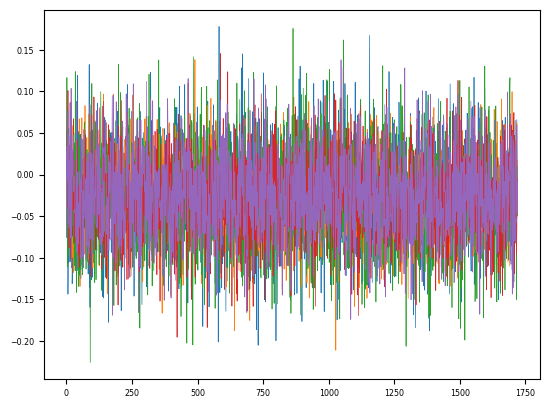

In [10]:
##### Visualize the generator signal 
#import matplotlib.pyplot as plt

## On HF ##
test_reg = load_model_HF(repo_id, model_id, 1720, 'full', perc=100)
# ### Locally ##
# test_reg = load_model(main_path, 1720, 'full', perc=perc)

# Generate spectra
z_train = torch.randn(5, test_reg.settings.latent_dim)#.to(device)

gen_spectra = test_reg.G(z_train)

pd.DataFrame(gen_spectra.squeeze(dim=1).cpu().detach().numpy()).T.plot(legend=False)